In [1]:
import os
import pandas as pd
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
import time

In [2]:
train_path = r'../dataset/train'
test_path = r'../dataset/test'
valid_path = r'../dataset/val'
working_dir = r'./' 
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [3]:
classes = os.listdir(train_path)
class_count = len(classes)
for cls in classes:
    class_path = os.path.join(train_path, cls)
    file_count = len(os.listdir(class_path))
    print('Class' , cls, ':', file_count)

Class 0 : 2286
Class 1 : 1046
Class 2 : 1516
Class 3 : 757
Class 4 : 173


In [4]:
def load_data(train_path, test_path, valid_path):
    for d in [train_path, test_path, valid_path]:
        file_paths = []
        labels = [] 
        class_list = os.listdir(d)   
        for cls in class_list:
            label = list_of_classes[int(cls)]
            class_path = os.path.join(d, cls)
            flist = os.listdir(class_path)        
            for f in flist:
                fpath = os.path.join(class_path, f)
                file_paths.append(fpath)
                labels.append(label)
        df = pd.DataFrame({
            'filepath': file_paths,
            'label': labels
        })

        if d == test_path:
            test_df = df
        elif d == valid_path:
            valid_df = df
        else:
            train_df = df
    print('train_df:', len(train_df), '\ntest_df:', len(test_df), '\nvalid_df:', len(valid_df))
    return train_df, test_df, valid_df

### Balance df

In [5]:
def trim(df, max_samples, column):
    groups = df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups = df.groupby(column)
    for label in df[column].unique(): 
        group = groups.get_group(label)
        count = len(group)    
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            sampled_group = group        
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
    return trimmed_df

In [6]:
def augment(df, n, aug_dir, img_size):
    print('Initial length of dataframe is ', len(df))
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['label'].unique():    
        dir_path = os.path.join(aug_dir, label)    
        os.mkdir(dir_path)

    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups = df.groupby('label')
    for label in df['label'].unique():           
        group = groups.get_group(label)
        sample_count = len(group)  
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            aug_gen = gen.flow_from_dataframe(group, x_col='filepath', y_col=None, target_size=(img_size, img_size),
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)            
                aug_img_count += len(images)
            total += aug_img_count
    print('Total augmented images created = ', total)

In [7]:
train_df, test_df, valid_df = load_data(train_path, test_path, valid_path)

train_df: 5778 
test_df: 1656 
valid_df: 826


In [8]:
train_df['label'].value_counts()

label
Healthy     2286
Minimal     1516
Doubtful    1046
Moderate     757
Severe       173
Name: count, dtype: int64

In [9]:
valid_df['label'].value_counts()

label
Healthy     328
Minimal     212
Doubtful    153
Moderate    106
Severe       27
Name: count, dtype: int64

In [10]:
max_train_samples = 500
max_valid_samples = 150

In [ ]:
train_df = augment(train_df, max_train_samples,  os.path.join(working_dir, 'train_aug'), 224)
valid_df = augment(valid_df, max_valid_samples, os.path.join(working_dir, 'val_aug'), 224)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total augmented images created =  327
Length of augmented dataframe is now  2500
Initial length of dataframe is  826
Found 106 validated image filenames.
Found 27 validated image filenames.
Total augmented images created =  167
Length of augmented dataframe is now  993


### Load dataset

In [11]:
def load_aug(df, aug_dir):
    aug_fpaths = []
    aug_labels = []
    classlist = os.listdir(aug_dir)
    for cls in classlist:
        class_path = os.path.join(aug_dir, cls)     
        flist = os.listdir(class_path)    
        for f in flist:        
            fpath = os.path.join(class_path,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(cls)
    aug_df = pd.DataFrame({
        'filepath': aug_fpaths,
        'label': aug_labels
    })         
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    return df 

In [12]:
train_df = trim(train_df, max_train_samples, 'label')
valid_df = trim(valid_df, max_valid_samples, 'label')

In [13]:
train_df = load_aug(train_df, './train_aug')
valid_df = load_aug(valid_df, './val_aug')

In [14]:
train_df['label'].value_counts()

label
Healthy     500
Doubtful    500
Minimal     500
Moderate    500
Severe      500
Name: count, dtype: int64

In [15]:
valid_df['label'].value_counts()

label
Healthy     150
Doubtful    150
Minimal     150
Moderate    150
Severe      150
Name: count, dtype: int64

In [16]:
def show_images(df):
    sampled_df = df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

    plt.figure(figsize=(20, 20))

    for i, row in sampled_df.iterrows():
        path = row['filepath']
        label = row['label']

        image = Image.open(path)
        image = image.convert("RGB")

        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.title(label, color='blue', fontsize=14)
        plt.axis('off')

    plt.show()

C:\Users\Dositej 14\AppData\Local\Temp\ipykernel_10492\1323024817.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)


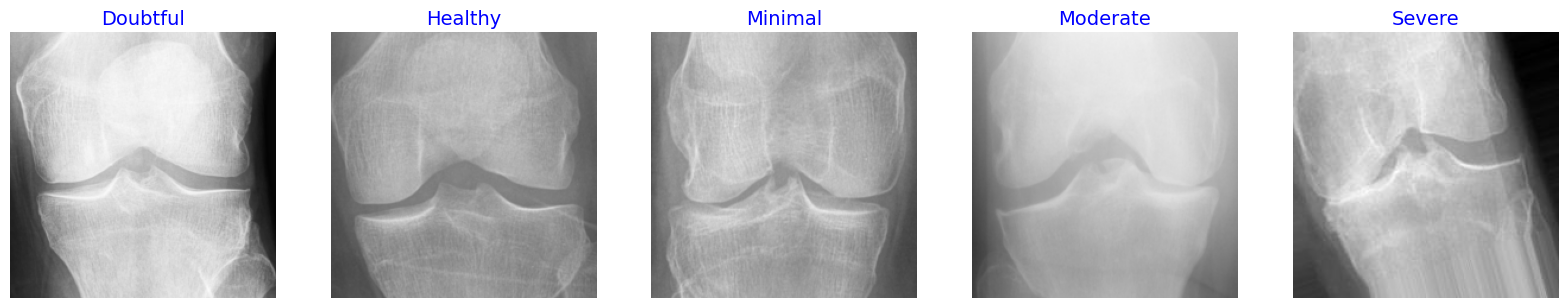

In [17]:
show_images(train_df)

In [18]:
dict = {
    'Healthy': 0,
    'Doubtful': 1,
    'Minimal': 2,
    'Moderate': 3,
    'Severe': 4
}

train_df['label'] = train_df['label'].map(dict.get)
valid_df['label'] = valid_df['label'].map(dict.get)
test_df['label'] = test_df['label'].map(dict.get)

In [19]:
def prepare_data(df, img_size):
    x = np.zeros((len(df), img_size, img_size, 3), np.uint8)
    y = np.zeros((len(df), 1), np.uint8)

    for i, row in df.iterrows():
        path = row['filepath']
        label = row['label']
        img = cv2.imread(path)
        cy = img.shape[0]
        cx = img.shape[1]
        if cx > cy:
            d = cx - cy
            img = cv2.copyMakeBorder(img, top=d//2, bottom=d-d//2, left=0, right=0,
                                    borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        else:
            d = cy - cx
            img = cv2.copyMakeBorder(img, top=0, bottom=0, left=d//2, right=d-d//2,
                                    borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
        x[i] = img
        y[i] = label

    rand_train_idx = np.random.RandomState(seed=0).permutation(len(df))
    x = x[rand_train_idx]
    y = y[rand_train_idx]

    return x, y

In [20]:
def predictor(model, batch_size, x_test, y_test):
    preds=model.predict(x_test, verbose=1, batch_size=batch_size)
    preds = np.argmax(preds, axis=1)
    cm = confusion_matrix(y_test, preds)
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()




#     y_pred= []
#     y_true=test_gen.labels
#     classes=list(test_gen.class_indices.keys())
#     class_count=len(classes)
#     errors=0
#     preds=model.predict(test_gen, verbose=1)
#     tests=len(preds)    
#     for i, p in enumerate(preds):        
#         pred_index=np.argmax(p)         
#         true_index=test_gen.labels[i]  # labels are integer values        
#         if pred_index != true_index: # a misclassification has occurred                                           
#             errors=errors + 1
#             file=test_gen.filenames[i]            
#         y_pred.append(pred_index)
            
#     acc=( 1-errors/tests) * 100
#     print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
#     ypred=np.array(y_pred)
#     ytrue=np.array(y_true)
#     if class_count <=30:
#         cm = confusion_matrix(ytrue, ypred )
#         # plot the confusion matrix
#         plt.figure(figsize=(12, 8))
#         sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
#         plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
#         plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
#         plt.xlabel("Predicted")
#         plt.ylabel("Actual")
#         plt.title("Confusion Matrix")
#         plt.show()
#     clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
#     print("Classification Report:\n----------------------\n", clr)
#     return errors, tests
# errors, tests=predictor(test_gen, test_steps)

In [21]:
batch_size = 16
epochs = 30
lr = .001

### ResNet50V2 - 5 klasa

In [110]:
img_size = 224

In [111]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [67]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [68]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'ResNet50V2_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [69]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [70]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3037 - loss: 5.3542
Epoch 1: val_loss improved from inf to 3.28716, saving model to ../ResNet50V2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.3040 - loss: 5.3494 - val_accuracy: 0.4267 - val_loss: 3.2872 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4513 - loss: 2.9692
Epoch 2: val_loss improved from 3.28716 to 2.77901, saving model to ../ResNet50V2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.4513 - loss: 2.9685 - val_accuracy: 0.4560 - val_loss: 2.7790 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4674 - loss: 2.5822
Epoch 3: val_loss did not improve from 2.77901
157/157 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.4674 - loss: 2.5812 - val_accuracy: 0.4227 - val_loss: 3.2054 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accur

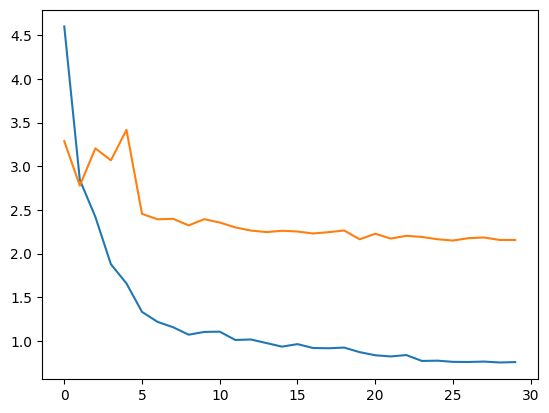

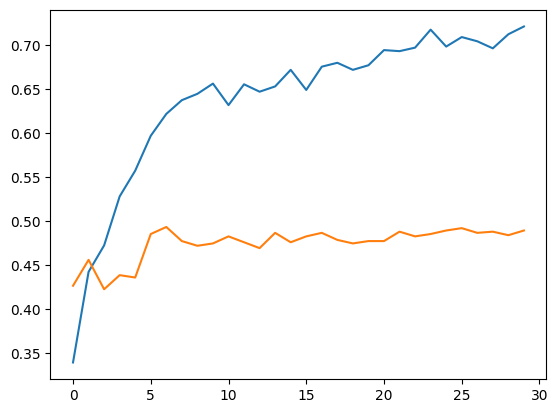

In [71]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step


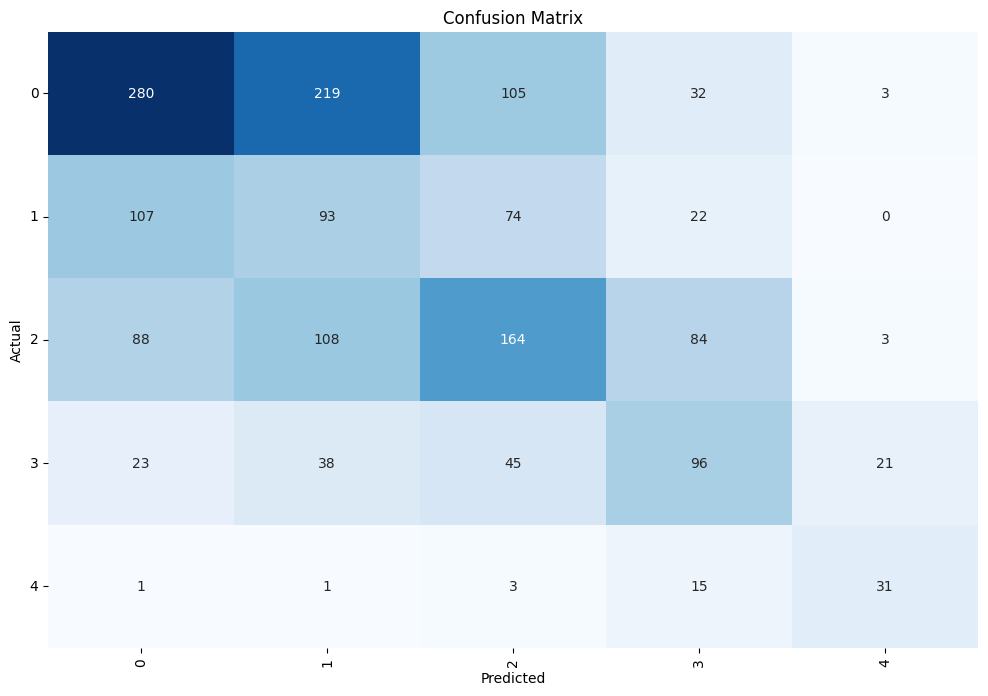

In [72]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [112]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [113]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'ResNet50V2_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [114]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [115]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2671 - loss: 4.3839
Epoch 1: val_loss improved from inf to 1101.26807, saving model to ../ResNet50V2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1069s 7s/step - accuracy: 0.2672 - loss: 4.3753 - val_accuracy: 0.2053 - val_loss: 1101.2681 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3039 - loss: 2.7469
Epoch 2: val_loss improved from 1101.26807 to 119.25533, saving model to ../ResNet50V2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 956s 6s/step - accuracy: 0.3038 - loss: 2.7458 - val_accuracy: 0.2693 - val_loss: 119.2553 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3092 - loss: 2.1468
Epoch 3: val_loss did not improve from 119.25533
157/157 ━━━━━━━━━━━━━━━━━━━━ 934s 6s/step - accuracy: 0.3091 - loss: 2.1480 - val_accuracy: 0.1933 - val_loss: 582.9180 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/

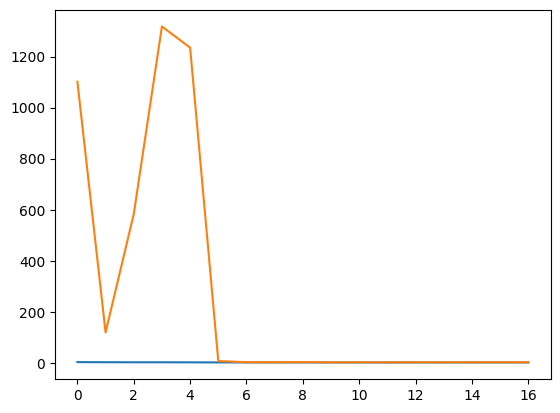

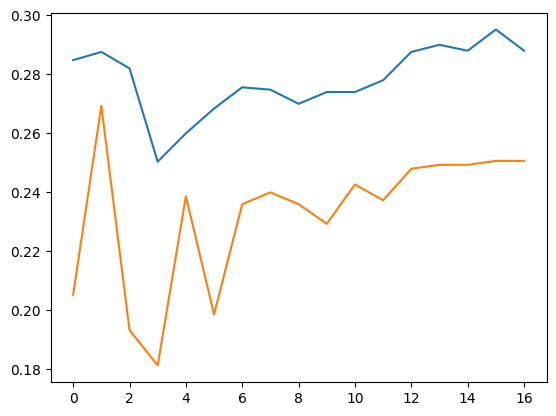

In [116]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step


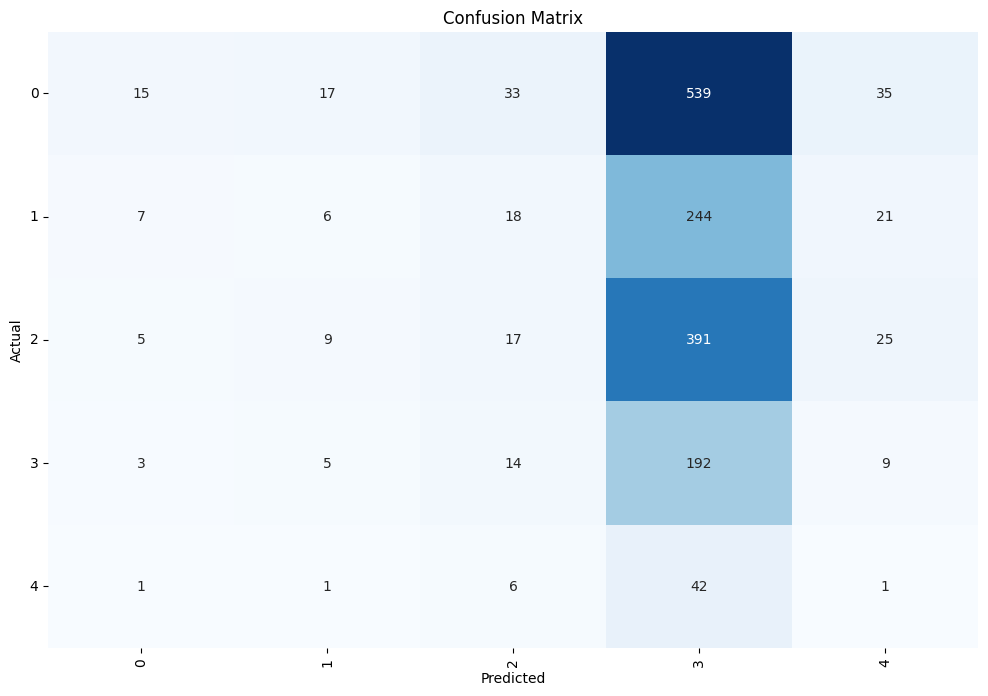

In [117]:
predictor(model, batch_size, x_test, y_test)

### EfficientNetB2 - 5 klasa

In [102]:
img_size = 260

In [103]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [104]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [105]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'EfficientNetB2_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [106]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [107]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2357 - loss: 4.5069
Epoch 1: val_loss improved from inf to 2.21394, saving model to ../EfficientNetB2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.2360 - loss: 4.5033 - val_accuracy: 0.3880 - val_loss: 2.2139 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3363 - loss: 3.1684
Epoch 2: val_loss did not improve from 2.21394
157/157 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.3363 - loss: 3.1676 - val_accuracy: 0.4067 - val_loss: 2.2309 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3574 - loss: 2.9033
Epoch 3: val_loss did not improve from 2.21394
157/157 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.3575 - loss: 2.9031 - val_accuracy: 0.4293 - val_loss: 2.5890 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3759 - loss: 2.5855
Epoch 4: val_loss did not impro

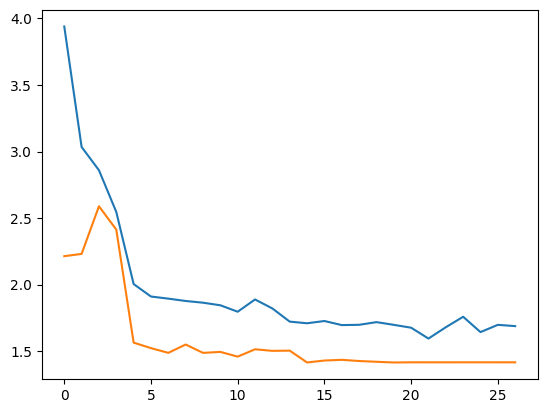

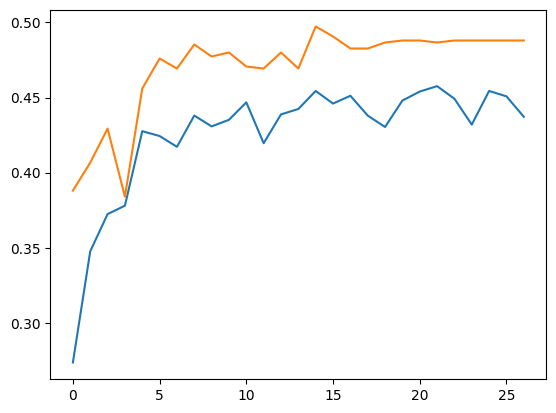

In [108]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step


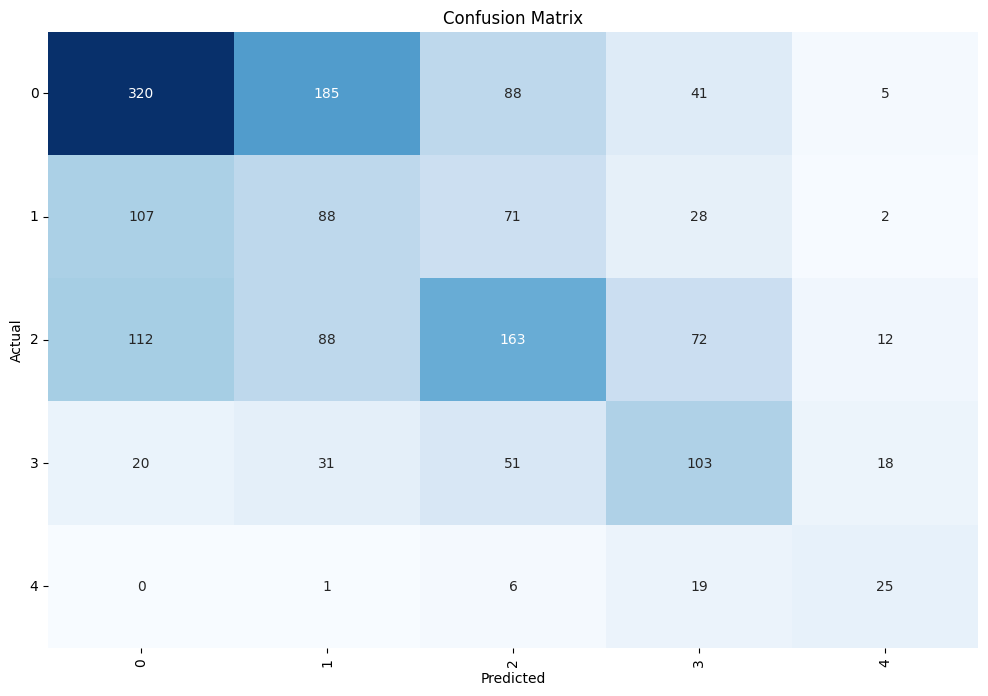

In [109]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [98]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [99]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'EfficientNetB2_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [100]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [101]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3998 - loss: 3.1630
Epoch 1: val_loss improved from inf to 1.77088, saving model to ../EfficientNetB2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1369s 8s/step - accuracy: 0.4001 - loss: 3.1562 - val_accuracy: 0.4747 - val_loss: 1.7709 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5616 - loss: 1.0083
Epoch 2: val_loss improved from 1.77088 to 1.70744, saving model to ../EfficientNetB2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1149s 7s/step - accuracy: 0.5616 - loss: 1.0081 - val_accuracy: 0.5427 - val_loss: 1.7074 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6424 - loss: 0.8103
Epoch 3: val_loss did not improve from 1.70744
157/157 ━━━━━━━━━━━━━━━━━━━━ 1154s 7s/step - accuracy: 0.6424 - loss: 0.8101 - val_accuracy: 0.5547 - val_loss: 1.7350 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - 

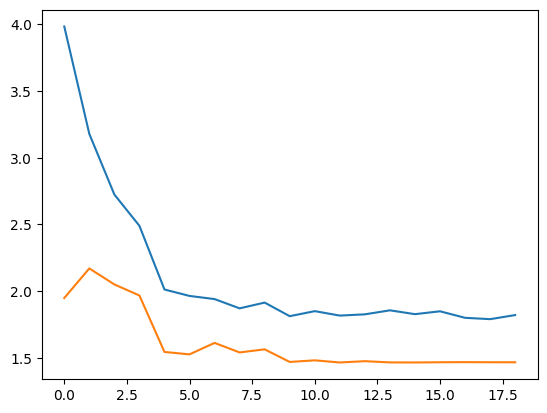

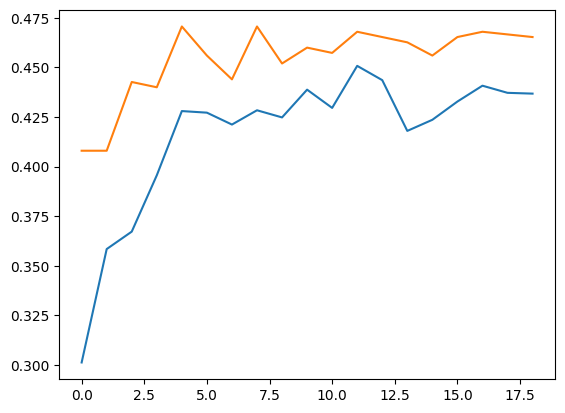

In [37]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step


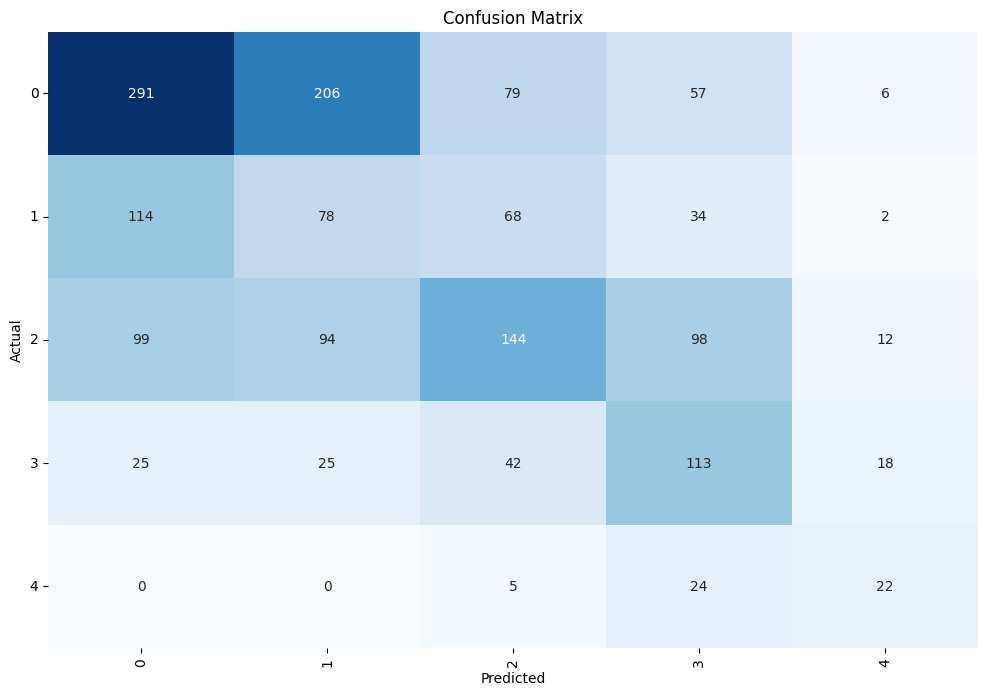

In [38]:
predictor(x_test, y_test)

### NASNetMobile - 5 klasa

In [22]:
img_size = 224

In [23]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [24]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [25]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'NASNetMobile_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [26]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [27]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2616 - loss: 2.9842
Epoch 1: val_loss improved from inf to 1.89693, saving model to ../NASNetMobile_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 759ms/step - accuracy: 0.2619 - loss: 2.9822 - val_accuracy: 0.3973 - val_loss: 1.8969 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3750 - loss: 2.1915
Epoch 2: val_loss did not improve from 1.89693
157/157 ━━━━━━━━━━━━━━━━━━━━ 111s 706ms/step - accuracy: 0.3750 - loss: 2.1916 - val_accuracy: 0.4227 - val_loss: 1.9994 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.4228 - loss: 1.9991
Epoch 3: val_loss improved from 1.89693 to 1.87882, saving model to ../NASNetMobile_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 724ms/step - accuracy: 0.4227 - loss: 1.9987 - val_accuracy: 0.4253 - val_loss: 1.8788 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━

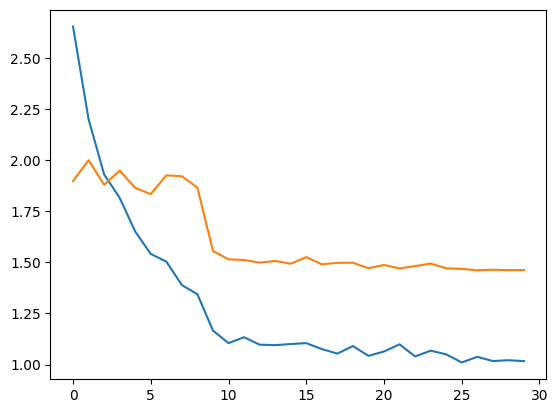

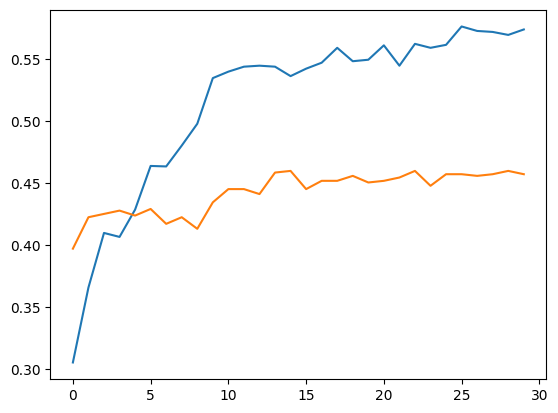

In [28]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 716ms/step


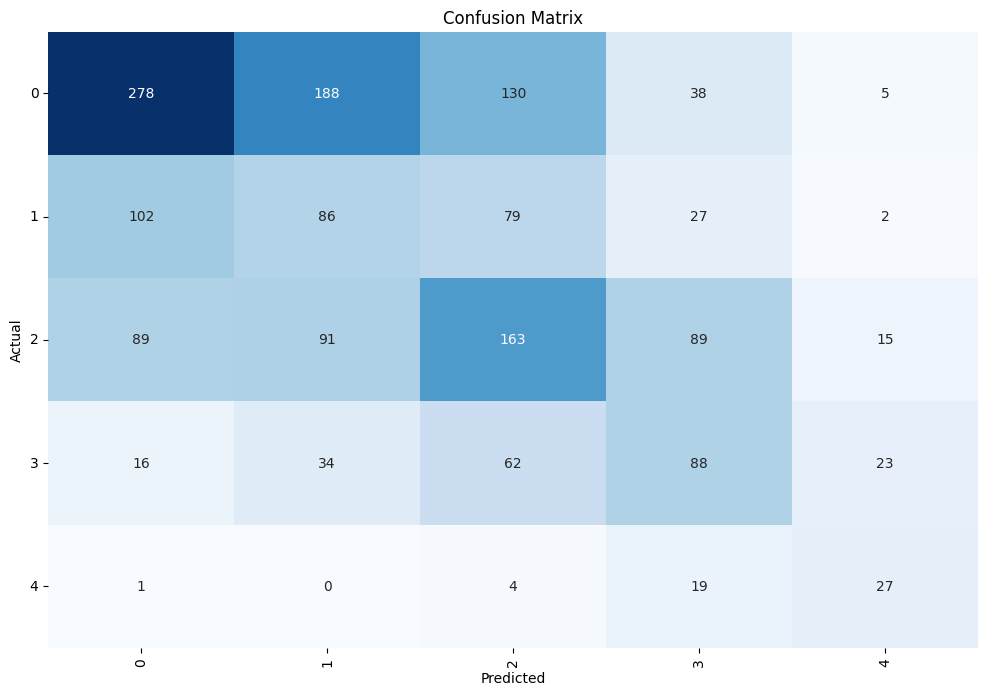

In [29]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [30]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [31]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'NASNetMobile_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [32]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [33]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3212 - loss: 2.9535
Epoch 1: val_loss improved from inf to 6.68705, saving model to ../NASNetMobile_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.3216 - loss: 2.9465 - val_accuracy: 0.2240 - val_loss: 6.6870 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5452 - loss: 1.0421
Epoch 2: val_loss improved from 6.68705 to 1.77213, saving model to ../NASNetMobile_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.5454 - loss: 1.0417 - val_accuracy: 0.2867 - val_loss: 1.7721 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6263 - loss: 0.8454
Epoch 3: val_loss did not improve from 1.77213
157/157 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.6264 - loss: 0.8451 - val_accuracy: 0.3907 - val_loss: 2.2500 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accurac

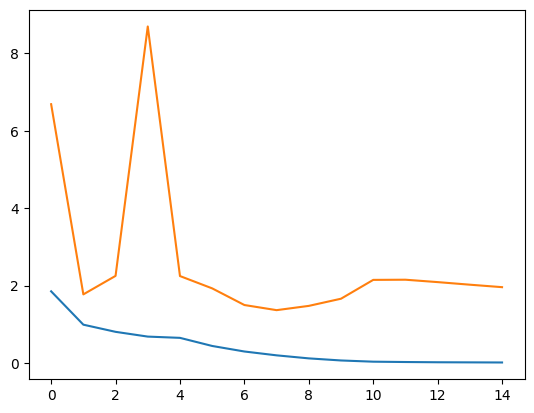

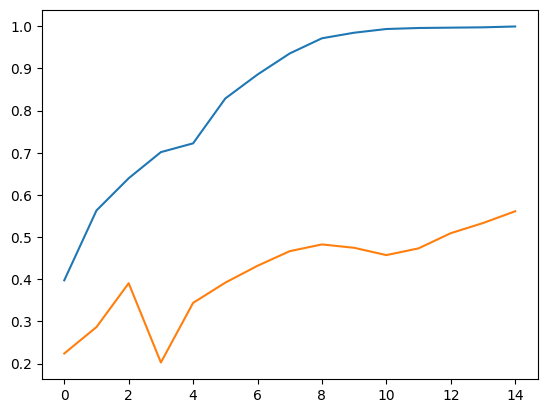

In [34]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 598ms/step


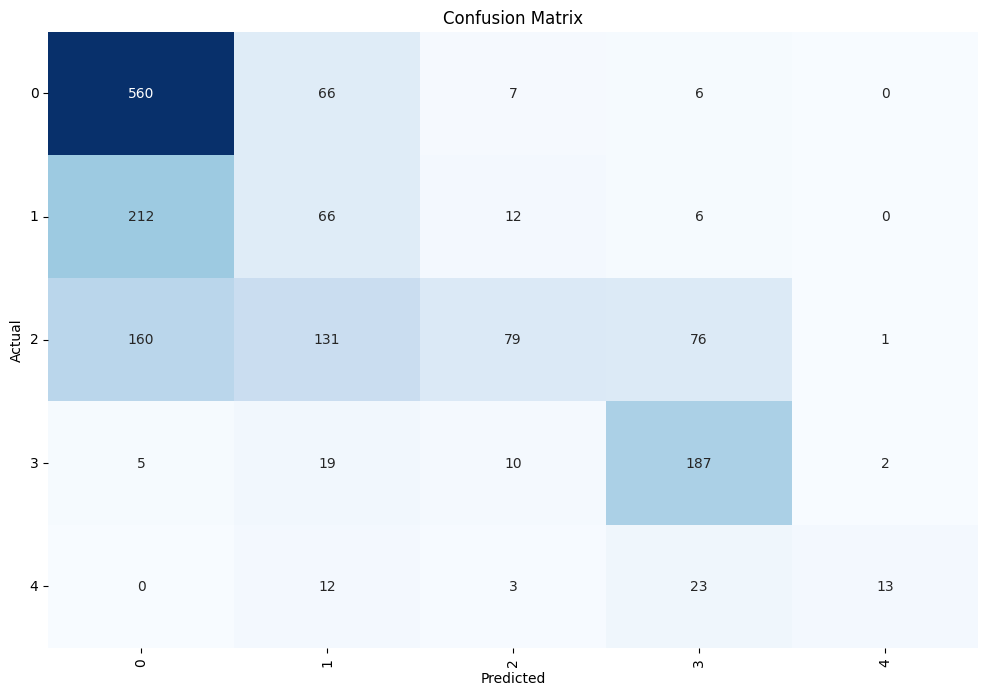

In [35]:
predictor(model, batch_size, x_test, y_test)

### XCeption - 5 klasa

In [22]:
img_size = 299

In [23]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [27]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [28]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'XCeption_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [29]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [30]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3349 - loss: 1.7018
Epoch 1: val_loss improved from inf to 1.46973, saving model to ../XCeption_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.3353 - loss: 1.7008 - val_accuracy: 0.4187 - val_loss: 1.4697 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4618 - loss: 1.3056
Epoch 2: val_loss improved from 1.46973 to 1.46321, saving model to ../XCeption_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.4617 - loss: 1.3057 - val_accuracy: 0.4280 - val_loss: 1.4632 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4975 - loss: 1.2267
Epoch 3: val_loss did not improve from 1.46321
157/157 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.4975 - loss: 1.2268 - val_accuracy: 0.4600 - val_loss: 1.4792 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy:

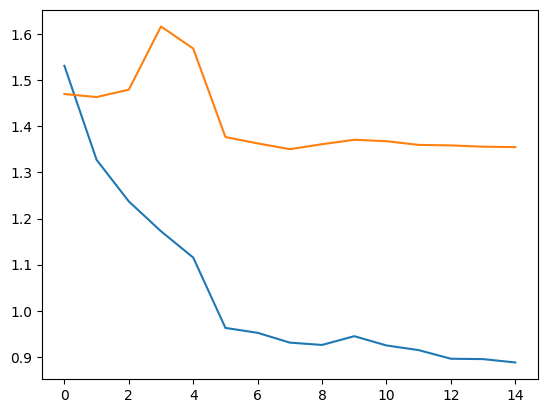

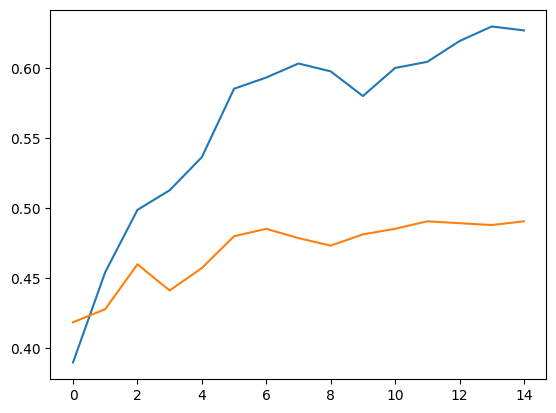

In [31]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step


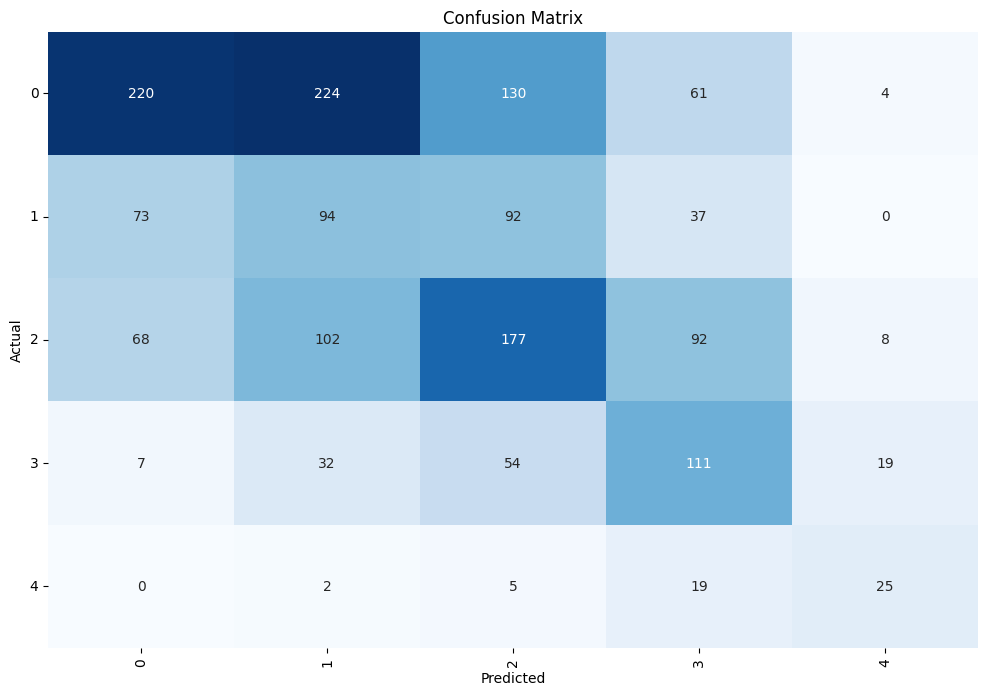

In [32]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [24]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [25]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'XCeption_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [26]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [27]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4109 - loss: 1.4113 
Epoch 1: val_loss improved from inf to 2.40673, saving model to ../XCeption_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 2756s 17s/step - accuracy: 0.4112 - loss: 1.4101 - val_accuracy: 0.4587 - val_loss: 2.4067 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5490 - loss: 1.0138 
Epoch 2: val_loss improved from 2.40673 to 1.26338, saving model to ../XCeption_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 2623s 17s/step - accuracy: 0.5491 - loss: 1.0134 - val_accuracy: 0.5427 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5977 - loss: 0.8649 
Epoch 3: val_loss did not improve from 1.26338
157/157 ━━━━━━━━━━━━━━━━━━━━ 2614s 17s/step - accuracy: 0.5979 - loss: 0.8647 - val_accuracy: 0.5093 - val_loss: 4.2029 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - ac

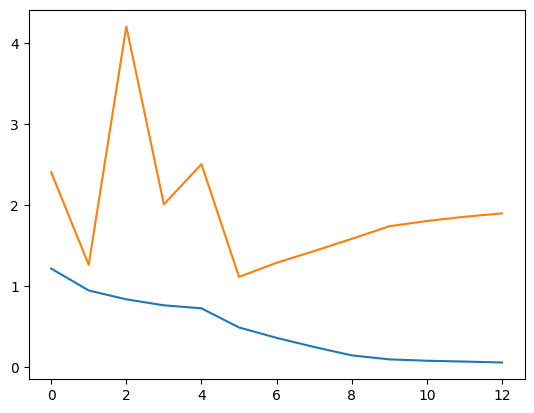

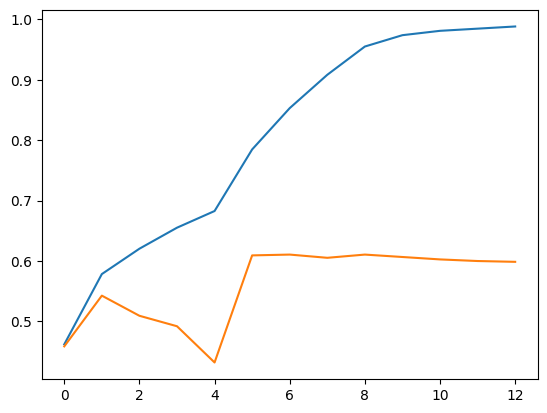

In [28]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step


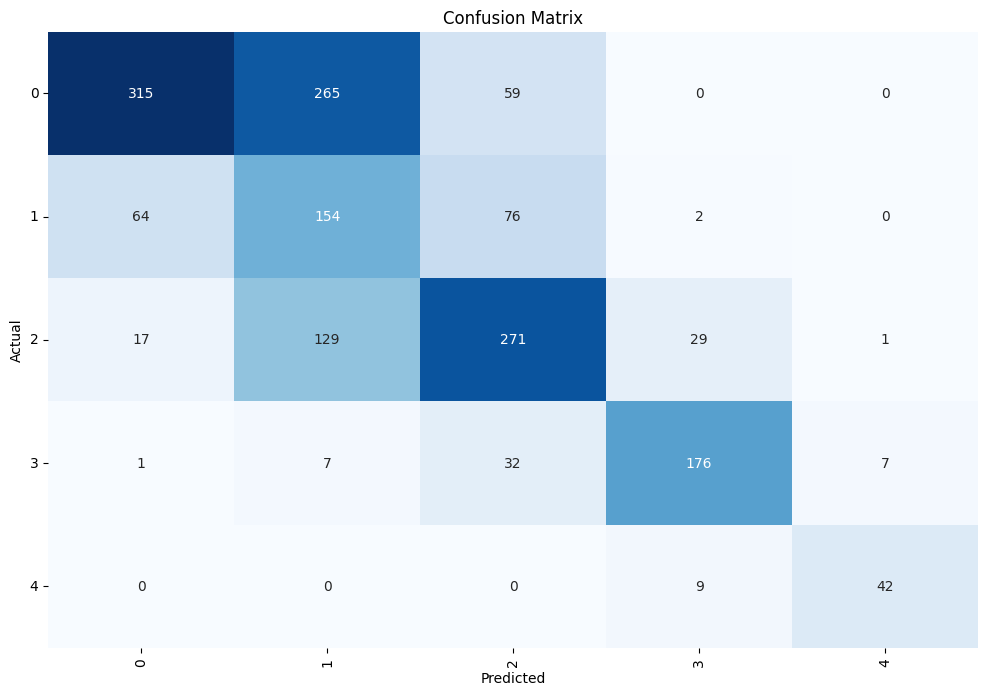

In [29]:
predictor(model, batch_size, x_test, y_test)

### TRI KLASE

In [30]:
drop_classes = [1, 2] # Minimal and Doubtful

train_df = train_df[~train_df['label'].isin(drop_classes)]
valid_df = valid_df[~valid_df['label'].isin(drop_classes)]  
test_df = test_df[~test_df['label'].isin(drop_classes)]

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

In [31]:
train_df['label'].value_counts()

label
0    500
3    500
4    500
Name: count, dtype: int64

In [32]:
test_df['label'].value_counts()

label
0    639
3    223
4     51
Name: count, dtype: int64

In [33]:
valid_df['label'].value_counts()

label
0    150
3    150
4    150
Name: count, dtype: int64

In [34]:
len(train_df)

1500

### EfficientNetB2 - 3 klase

In [27]:
img_size = 260

In [28]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [45]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [46]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'EfficientNetB2_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [47]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [48]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4235 - loss: 3.2346
Epoch 1: val_loss improved from inf to 2.51921, saving model to ../EfficientNetB2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.4240 - loss: 3.2284 - val_accuracy: 0.4422 - val_loss: 2.5192 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5539 - loss: 2.0732
Epoch 2: val_loss improved from 2.51921 to 1.46767, saving model to ../EfficientNetB2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.5541 - loss: 2.0713 - val_accuracy: 0.5644 - val_loss: 1.4677 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6033 - loss: 1.6018
Epoch 3: val_loss did not improve from 1.46767
94/94 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6034 - loss: 1.6021 - val_accuracy: 0.5467 - val_loss: 1.6206 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0

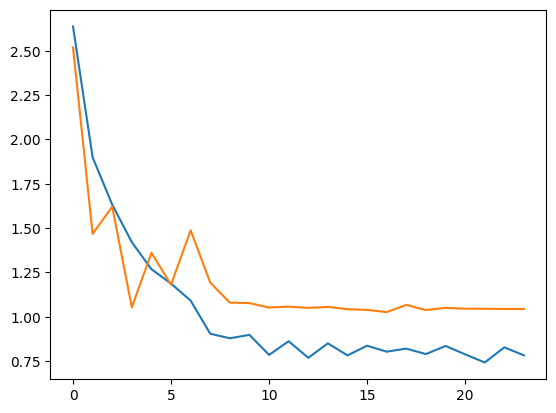

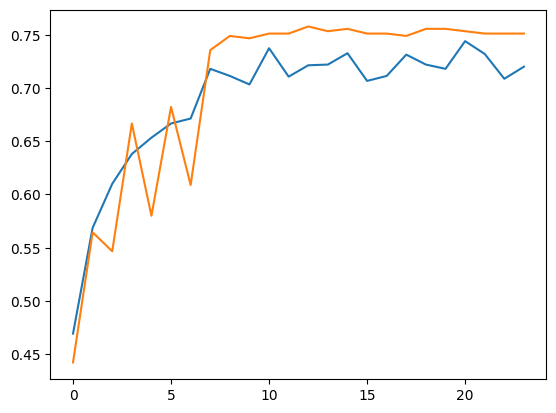

In [49]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step


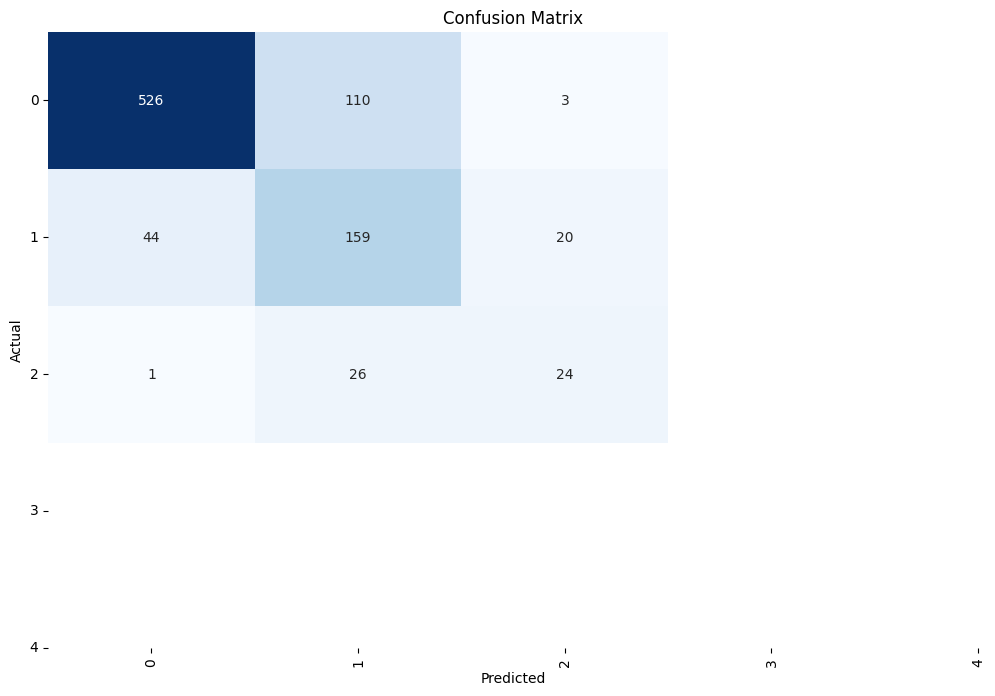

In [50]:
predictor(x_test, y_test)

#### Full

In [29]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [30]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'EfficientNetB2_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [31]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [32]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5702 - loss: 2.8554
Epoch 1: val_loss improved from inf to 3.79102, saving model to ../EfficientNetB2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 848s 8s/step - accuracy: 0.5712 - loss: 2.8455 - val_accuracy: 0.6400 - val_loss: 3.7910 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8210 - loss: 0.7550
Epoch 2: val_loss did not improve from 3.79102
94/94 ━━━━━━━━━━━━━━━━━━━━ 707s 8s/step - accuracy: 0.8215 - loss: 0.7519 - val_accuracy: 0.6622 - val_loss: 10.5802 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9401 - loss: 0.1698
Epoch 3: val_loss did not improve from 3.79102
94/94 ━━━━━━━━━━━━━━━━━━━━ 672s 7s/step - accuracy: 0.9402 - loss: 0.1694 - val_accuracy: 0.6667 - val_loss: 8.9653 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9784 - loss: 0.0617
Epoch 4: val_loss did not improve from 3.79102


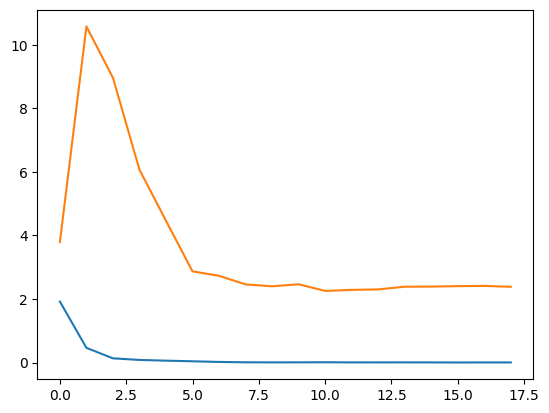

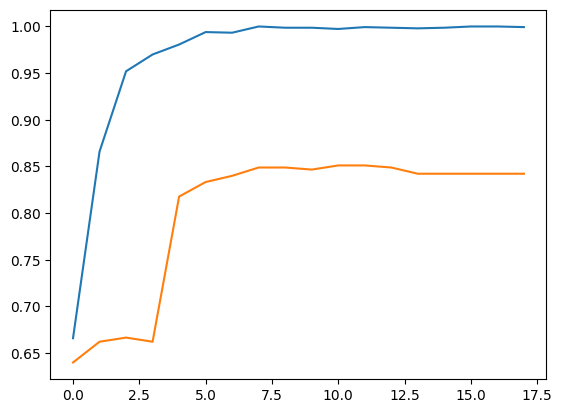

In [33]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step


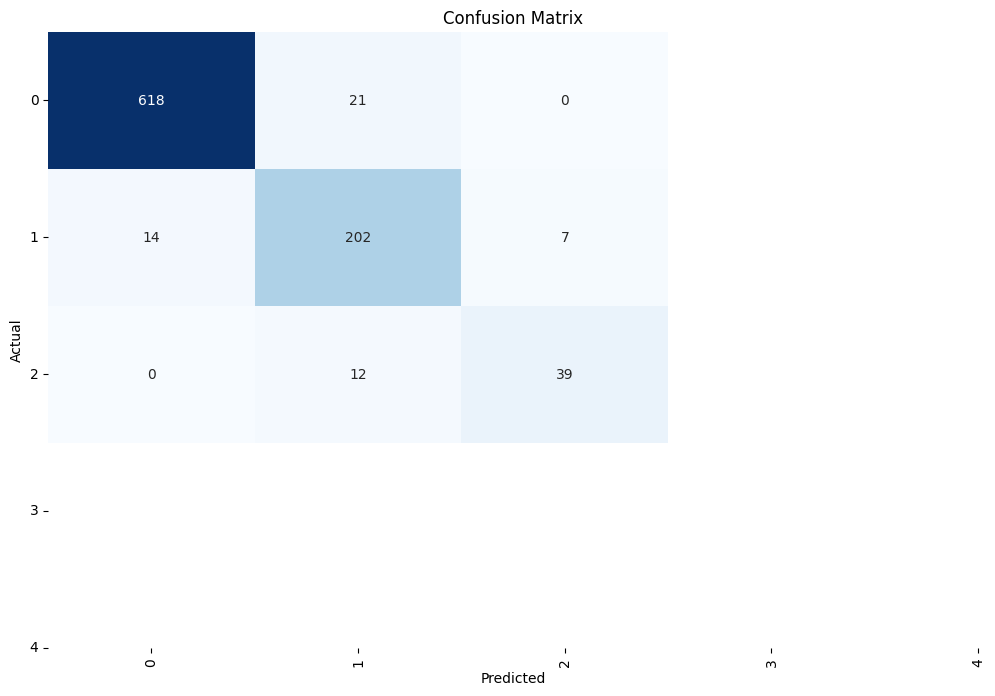

In [35]:
predictor(model, batch_size, x_test, y_test)

### ResNet50V2 - 3 klase

In [36]:
img_size = 224

In [37]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [80]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [81]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'ResNet50V2_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [82]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [83]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4650 - loss: 3.9250
Epoch 1: val_loss improved from inf to 2.61641, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.4658 - loss: 3.9131 - val_accuracy: 0.6067 - val_loss: 2.6164 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6720 - loss: 1.7007
Epoch 2: val_loss improved from 2.61641 to 2.30688, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6721 - loss: 1.6986 - val_accuracy: 0.6489 - val_loss: 2.3069 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7673 - loss: 1.0469
Epoch 3: val_loss improved from 2.30688 to 1.87197, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7674 - loss: 1.0469 - val_accuracy: 0.7333 - val_loss: 1.8720 - learning_rate: 0.0010
Epoch 4/

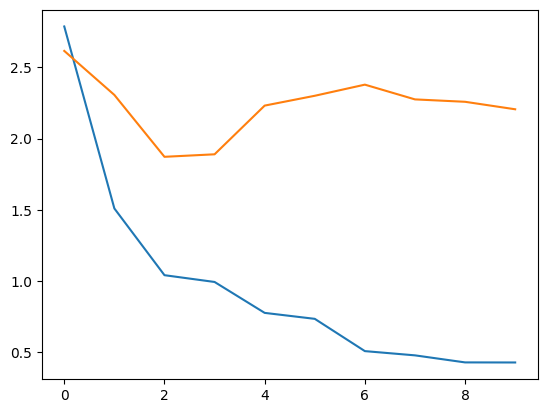

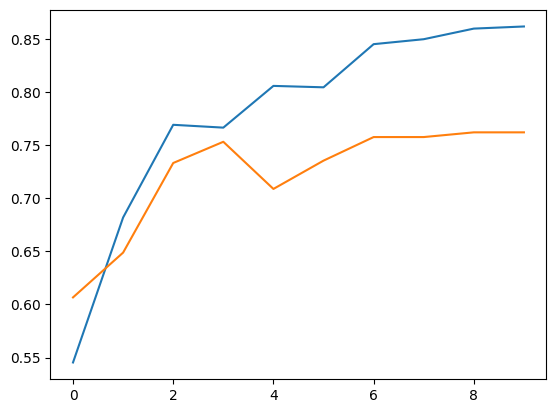

In [84]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step


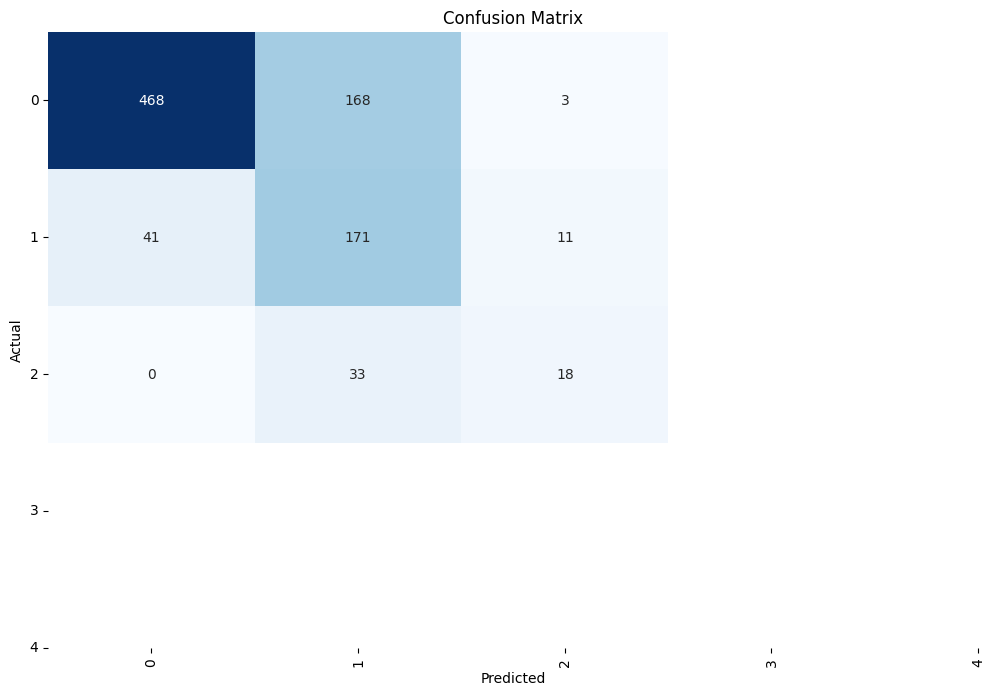

In [85]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [38]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [39]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'ResNet50V2_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [40]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [41]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5073 - loss: 4.4767
Epoch 1: val_loss improved from inf to 35.05415, saving model to ../ResNet50V2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 632s 6s/step - accuracy: 0.5078 - loss: 4.4589 - val_accuracy: 0.3644 - val_loss: 35.0541 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6471 - loss: 1.1666
Epoch 2: val_loss improved from 35.05415 to 3.57982, saving model to ../ResNet50V2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 586s 6s/step - accuracy: 0.6475 - loss: 1.1652 - val_accuracy: 0.5311 - val_loss: 3.5798 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6848 - loss: 0.8258
Epoch 3: val_loss did not improve from 3.57982
94/94 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - accuracy: 0.6850 - loss: 0.8266 - val_accuracy: 0.6222 - val_loss: 41.9600 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7417 - lo

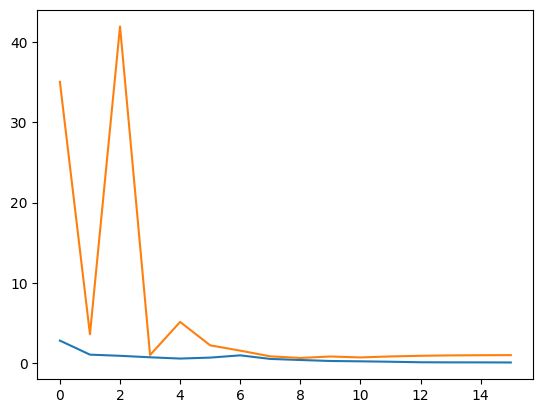

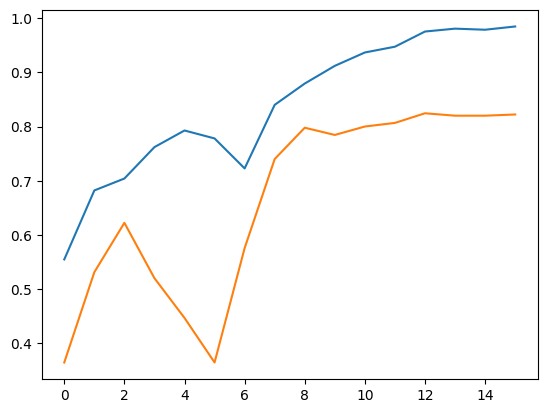

In [42]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step


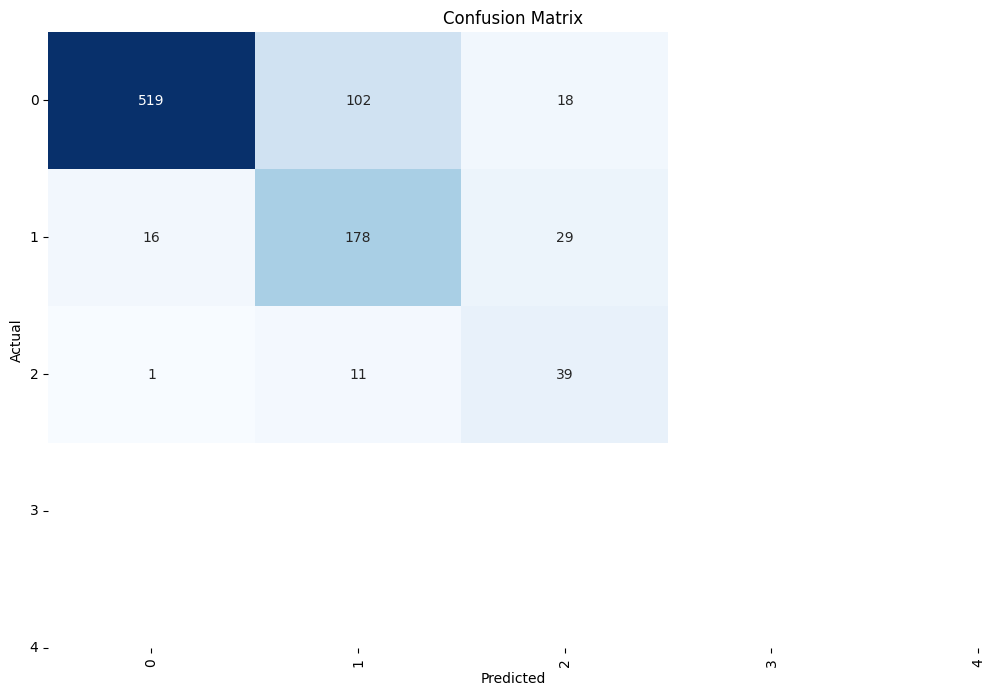

In [43]:
predictor(model, batch_size, x_test, y_test)

### NASNetMobile - 3 klase

In [52]:
img_size = 224

In [53]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [46]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [47]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'NASNetMobile_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [48]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [49]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4389 - loss: 2.4253
Epoch 1: val_loss improved from inf to 1.33721, saving model to ../NASNetMobile_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 114s 826ms/step - accuracy: 0.4398 - loss: 2.4179 - val_accuracy: 0.5844 - val_loss: 1.3372 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6141 - loss: 1.1234
Epoch 2: val_loss improved from 1.33721 to 1.28487, saving model to ../NASNetMobile_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 744ms/step - accuracy: 0.6143 - loss: 1.1231 - val_accuracy: 0.5956 - val_loss: 1.2849 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6700 - loss: 1.0199
Epoch 3: val_loss did not improve from 1.28487
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.6700 - loss: 1.0199 - val_accuracy: 0.5889 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/ste

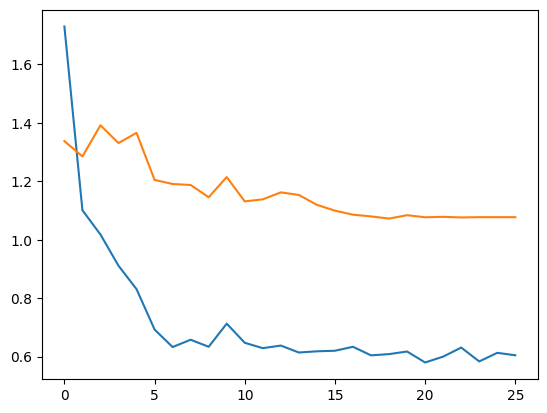

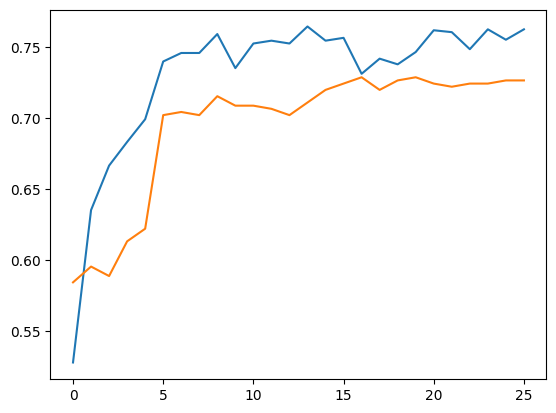

In [50]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 46s 660ms/step


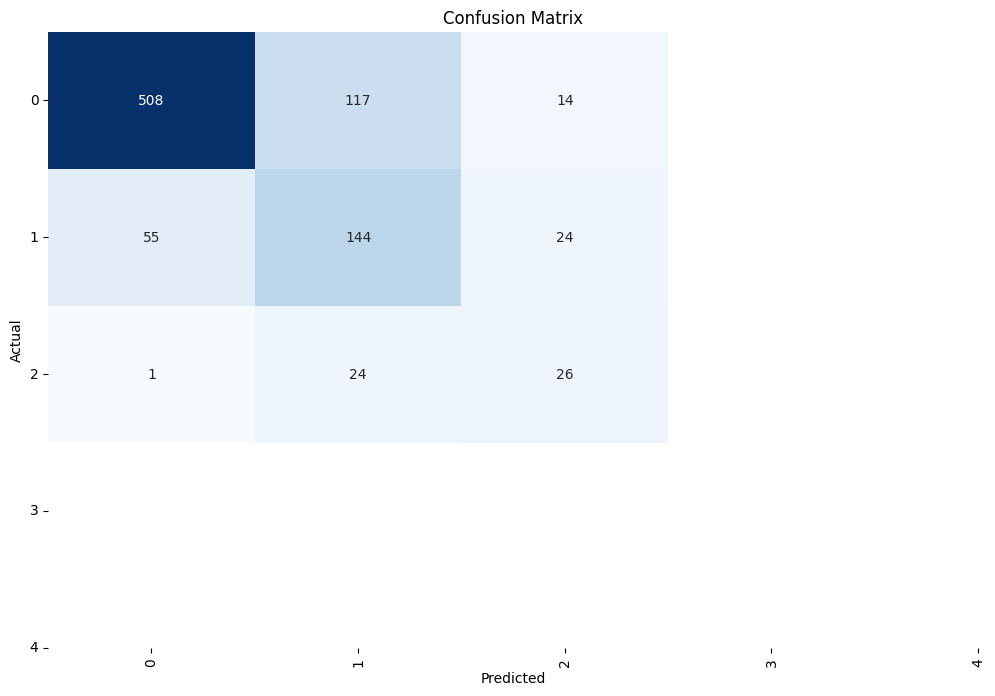

In [51]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [55]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [54]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'NASNetMobile_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [56]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [57]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5858 - loss: 2.4570
Epoch 1: val_loss improved from inf to 6.06091, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.5866 - loss: 2.4481 - val_accuracy: 0.3733 - val_loss: 6.0609 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7959 - loss: 0.5682
Epoch 2: val_loss improved from 6.06091 to 4.04898, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7965 - loss: 0.5666 - val_accuracy: 0.4111 - val_loss: 4.0490 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8963 - loss: 0.2679
Epoch 3: val_loss improved from 4.04898 to 3.00162, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.8965 - loss: 0.2676 - val_accuracy: 0.4956 - val_loss: 3.0016 - learning_rate: 0.0010
Epoch 4/30


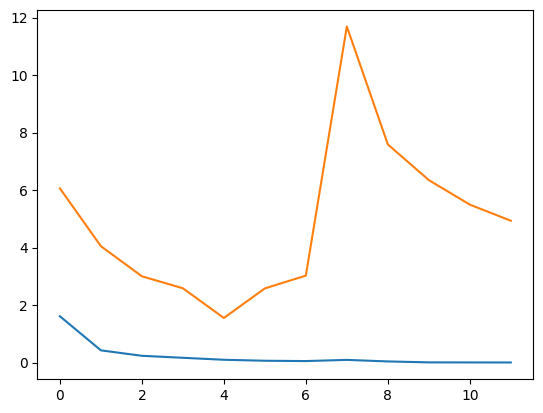

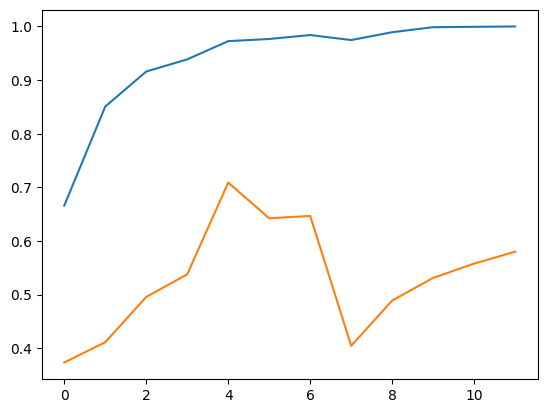

In [60]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))

58/58 ━━━━━━━━━━━━━━━━━━━━ 45s 678ms/step


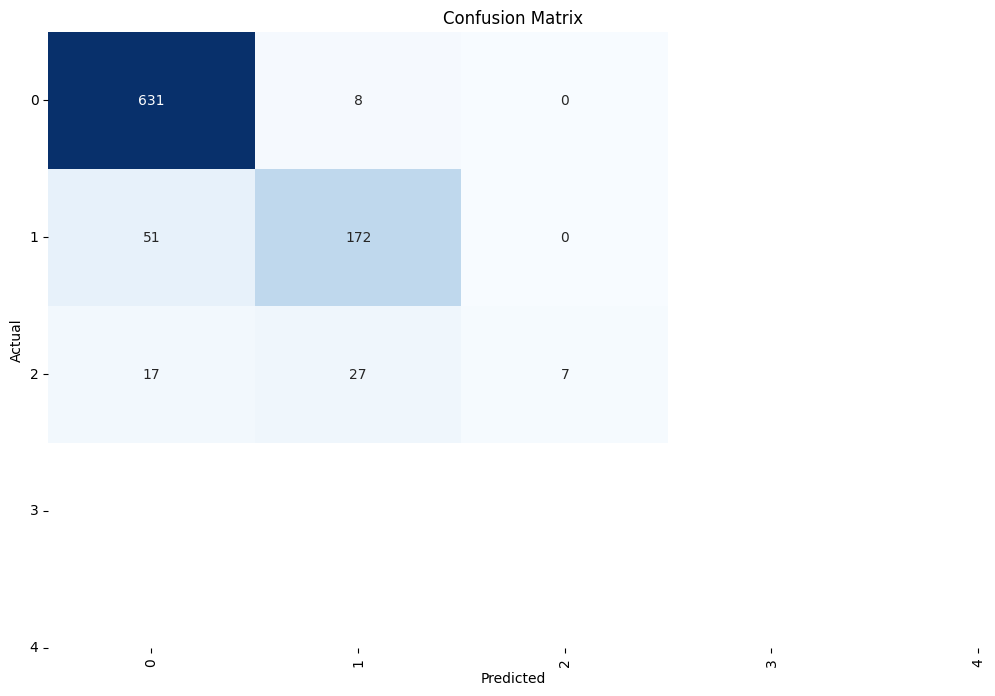

In [59]:
predictor(model, batch_size, x_test, y_test)

### XCeption - 3 klase

In [35]:
img_size = 299

In [36]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [37]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [38]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'XCeption_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [39]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [40]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5474 - loss: 1.0227
Epoch 1: val_loss improved from inf to 0.93681, saving model to ../XCeption_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.5483 - loss: 1.0205 - val_accuracy: 0.6000 - val_loss: 0.9368 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6886 - loss: 0.6810
Epoch 2: val_loss improved from 0.93681 to 0.79150, saving model to ../XCeption_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.6888 - loss: 0.6806 - val_accuracy: 0.6867 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7595 - loss: 0.5569
Epoch 3: val_loss did not improve from 0.79150
94/94 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.7596 - loss: 0.5567 - val_accuracy: 0.7178 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7774 - loss

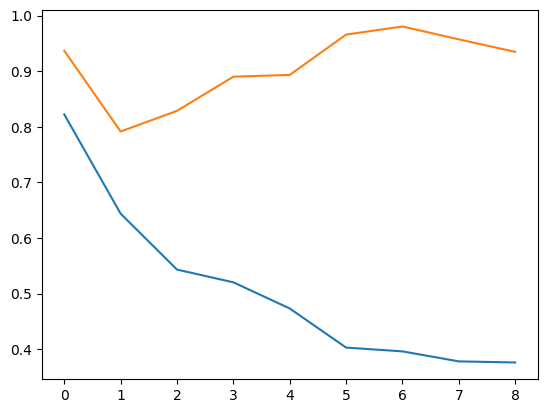

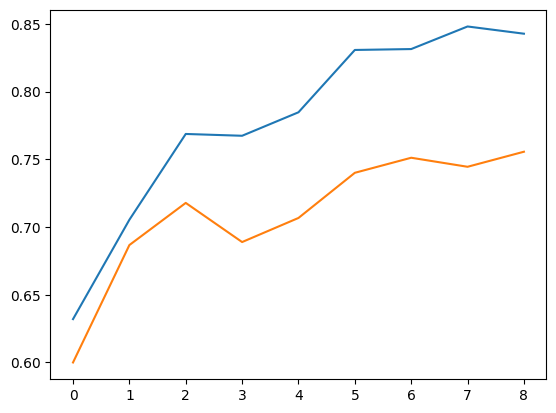

In [41]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step


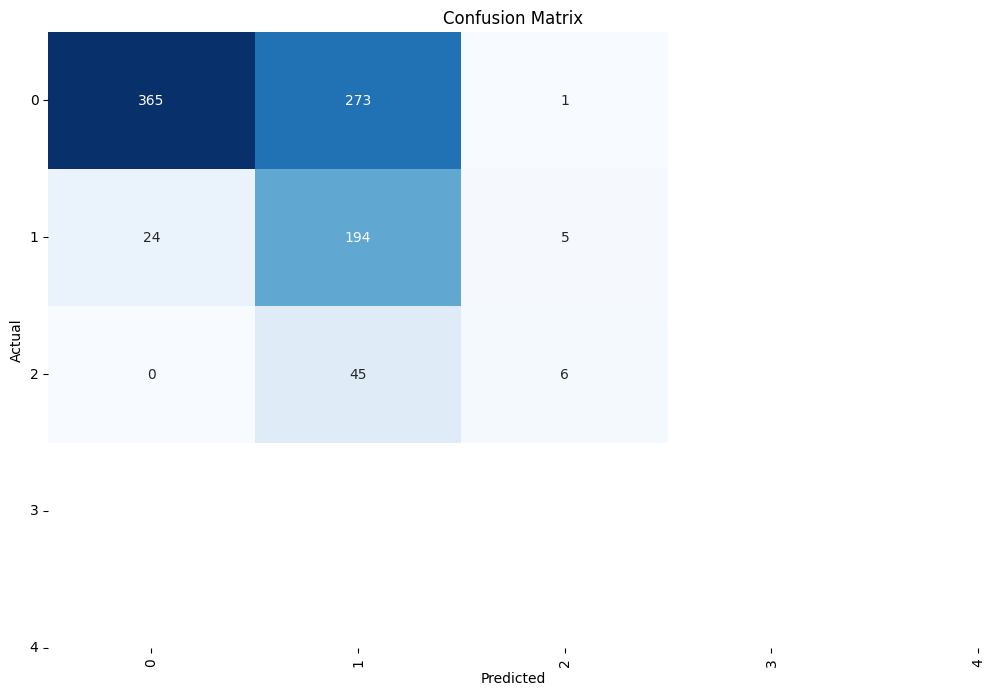

In [42]:
predictor(model, batch_size, x_test, y_test)

#### Full

In [43]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
root_folder = '../'

tmp_folder = os.path.join(root_folder, 'XCeption_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [45]:
path = os.path.join(tmp_folder, 'model.keras')

save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                  patience=7, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                 factor=0.1, patience=3, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

In [46]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[save_model, early_stopping, reduce_lr, csv_logger],  
                  validation_data=(x_valid, y_valid),
               validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6559 - loss: 0.9451 
Epoch 1: val_loss improved from inf to 2.89013, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1707s 17s/step - accuracy: 0.6568 - loss: 0.9420 - val_accuracy: 0.7422 - val_loss: 2.8901 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8378 - loss: 0.4502 
Epoch 2: val_loss improved from 2.89013 to 2.26270, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1561s 17s/step - accuracy: 0.8380 - loss: 0.4496 - val_accuracy: 0.8467 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9057 - loss: 0.3036 
Epoch 3: val_loss improved from 2.26270 to 0.72266, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1548s 16s/step - accuracy: 0.9058 - loss: 0.3032 - val_accuracy: 0.8667 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 4/30


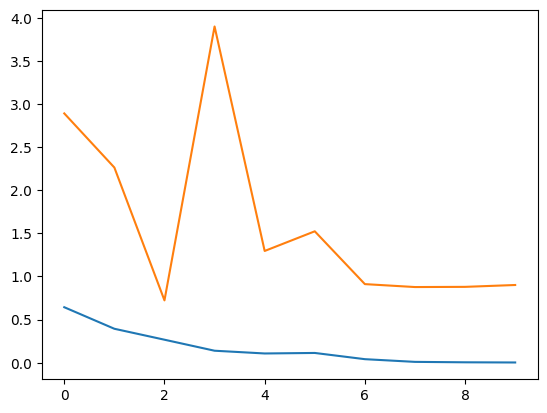

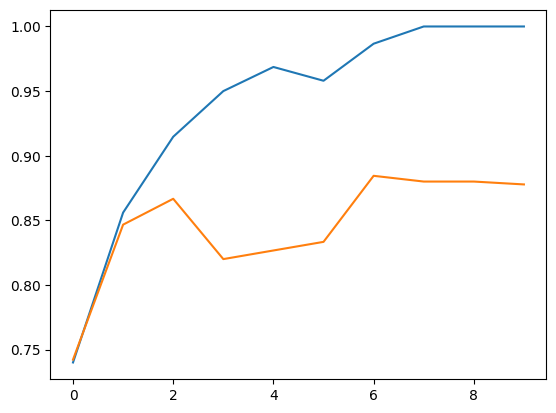

In [47]:
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig(os.path.join(tmp_folder, 'training_loss.png'))
plt.show()

plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.savefig(os.path.join(tmp_folder, 'training_accuracy.png'))
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step


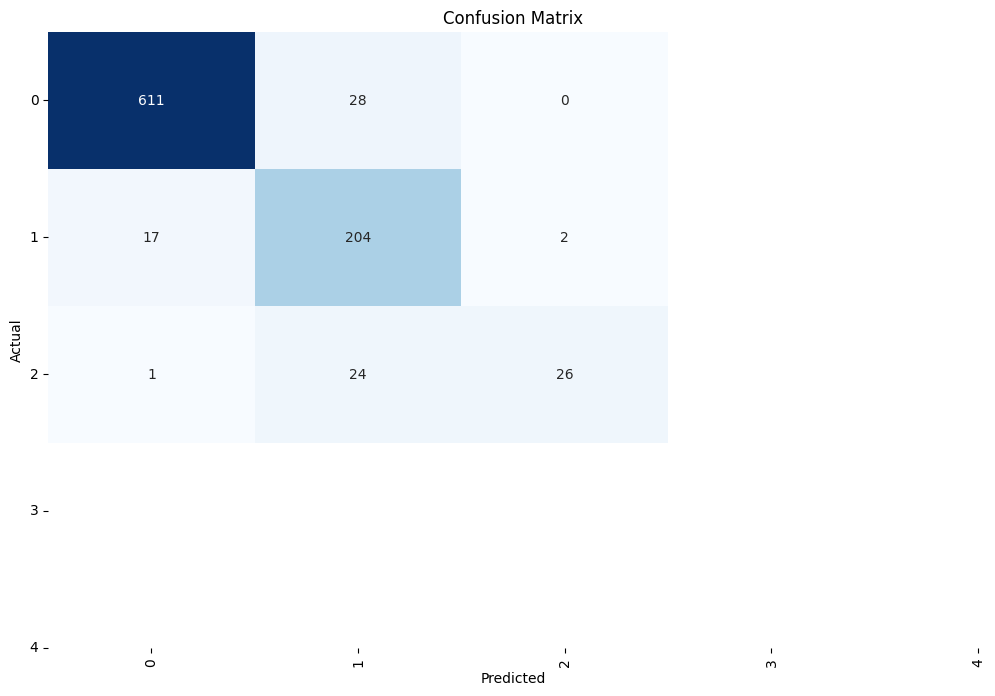

In [48]:
predictor(model, batch_size, x_test, y_test)